In [5]:
import os
import sys

import time
import numpy as np
import pandas as pd

import sys
import argparse

import matplotlib.pyplot as plt
from sklearn.svm import OneClassSVM
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.decomposition import PCA

import metrics

np.random.seed(1)

train_In_size = 8000
train_OoD_size = 0

exp_var_ratio = 0.95
import pandas as pd

train_id = pd.read_csv("./train.csv")
test_id = pd.read_csv("./test.csv")
ood_id = pd.read_csv("./ood.csv")
ood_train_id = pd.read_csv("./ood_train.csv")

cache_name = os.path.join('./', "CIFAR10_ResNet18_ce_pretrain_features_test.npy")
CIFAR10_test = np.load(cache_name, allow_pickle=True)
cache_name = os.path.join('./', "CIFAR10_ResNet18_ce_pretrain_features_DTD.npy")
DTD = np.load(cache_name, allow_pickle=True)

train = CIFAR10_test[train_id.T.to_numpy()[0]-1]

shuffled_train = np.random.permutation(train)
train = shuffled_train[:train_In_size]

test = CIFAR10_test[test_id.T.to_numpy()[0]-1]
ood = DTD[ood_id.T.to_numpy()[0]-1] #ood_id.T.to_numpy()[0]-1

ood_train = DTD[ood_train_id.T.to_numpy()[0]-1]
shuffled_ood_train = np.random.permutation(ood_train)
ood_train = shuffled_ood_train[:train_OoD_size]
# train = np.vstack((train, ood_train))
train = np.vstack((test, ood))

# PCA step
pca = PCA(n_components=50)
train = pca.fit_transform(train)  # Fit & transform train
test = pca.transform(test) 
ood = pca.transform(ood) 

# scale data
scaler = StandardScaler()
X_train = scaler.fit_transform(train)
X_test = scaler.transform(test)
X_outliers = scaler.transform(ood)

# Initialize One-Class SVM
oc_svm = OneClassSVM(kernel='poly', gamma='scale', nu = 0.1)

# Train the model
oc_svm.fit(X_train)

OneClassSVM(kernel='poly', nu=0.1)

In [6]:
y_predval_train = oc_svm.decision_function(X_train)
y_predval_test = oc_svm.decision_function(X_test)
y_predval_outliers = oc_svm.decision_function(X_outliers)

np.save("./OCSVM_In.npy", y_predval_test)
np.save("./OCSVM_OOD.npy", y_predval_outliers)

metrics.cal_metric(y_predval_test, y_predval_outliers)

{'FPR': 0.819,
 'AUROC': 0.542294,
 'DTERR': 0.29533333333333334,
 'AUIN': 0.6659292499674898,
 'AUOUT': 0.45512962314165706}

In [9]:
y_predval_test

array([0.60748466, 0.22595639, 0.95090323, ..., 0.23163617, 1.37350588,
       0.15416744])

In [75]:
# Predict
y_pred_train = oc_svm.predict(X_train)
y_pred_test = oc_svm.predict(X_test)
y_pred_outliers = oc_svm.predict(X_outliers)

# Replace -1 with 0 for anomaly detection
y_pred_train = [0 if x == -1 else 1 for x in y_pred_train]
y_pred_test = [0 if x == -1 else 1 for x in y_pred_test]
y_pred_outliers = [0 if x == -1 else 1 for x in y_pred_outliers]

# True labels
y_true_train = [1] * len(y_pred_train)
y_true_test = [1] * len(y_pred_test)
y_true_outliers = [0] * len(y_pred_outliers)

# Combine predictions and true labels
y_true = y_true_train
y_pred = y_pred_train

# Print classification report
print("Train data\n")
print(classification_report(y_true, y_pred))



# Combine predictions and true labels
y_true = y_true_test + y_true_outliers
y_pred = y_pred_test + y_pred_outliers

# Print classification report
print("Test data\n")
print(classification_report(y_true, y_pred))

Train data

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.50      0.67      8000

    accuracy                           0.50      8000
   macro avg       0.50      0.25      0.33      8000
weighted avg       1.00      0.50      0.67      8000

Test data

              precision    recall  f1-score   support

           0       0.09      0.10      0.09      1000
           1       0.53      0.52      0.53      2000

    accuracy                           0.38      3000
   macro avg       0.31      0.31      0.31      3000
weighted avg       0.39      0.38      0.38      3000



/Users/zhexuanliu/Documents/environments/LLM_Bio/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/zhexuanliu/Documents/environments/LLM_Bio/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/zhexuanliu/Documents/environments/LLM_Bio/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

In [34]:
sum(y_pred_train)

7198

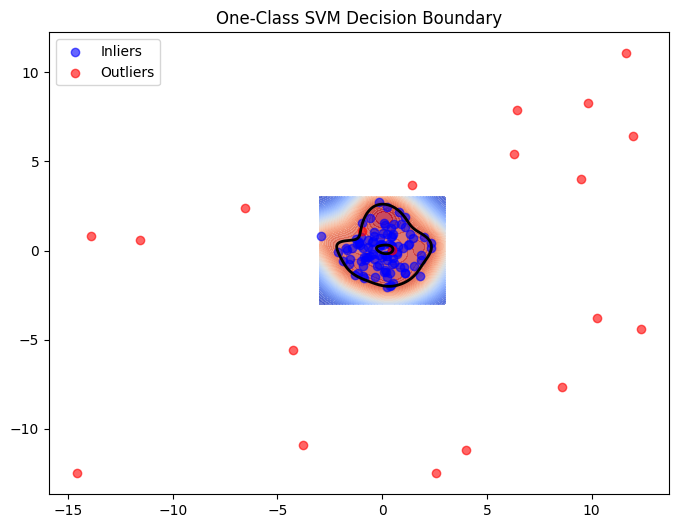

In [70]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import OneClassSVM
from sklearn.preprocessing import StandardScaler

# Generate synthetic inliers (normal data)
np.random.seed(42)
X_train = 0.3 * np.random.randn(100, 2)

# Generate outliers (OOD data)
X_outliers = np.random.uniform(low=-4, high=4, size=(20, 2))

# Scale data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_outliers = scaler.transform(X_outliers)

# Train One-Class SVM
oc_svm = OneClassSVM(kernel="rbf", gamma=0.5, nu=0.1)
oc_svm.fit(X_train)

# Generate a grid for visualization
xx, yy = np.meshgrid(np.linspace(-3, 3, 100), np.linspace(-3, 3, 100))
Z = oc_svm.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Plot decision boundary
plt.figure(figsize=(8, 6))
plt.contourf(xx, yy, Z, levels=np.linspace(Z.min(), Z.max(), 50), cmap=plt.cm.coolwarm, alpha=0.75)
plt.contour(xx, yy, Z, levels=[0], linewidths=2, colors="black")  # Decision boundary

# Plot inliers and outliers
plt.scatter(X_train[:, 0], X_train[:, 1], c='blue', label="Inliers", alpha=0.6)
plt.scatter(X_outliers[:, 0], X_outliers[:, 1], c='red', label="Outliers", alpha=0.6)
plt.legend()
plt.title("One-Class SVM Decision Boundary")
plt.show()


In [31]:
import random
print(random.randint(1,6))

6
